<a href="https://colab.research.google.com/github/cassmasschelein/CHEM-3RP3/blob/master/Introduction_to_ML_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [3]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 57 kB 620 kB/s 


In [4]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [5]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170498071/170498071 [==============================] - 6s 0us/step


In [10]:
print(X_train.shape)

(48000, 3, 32, 32)



Next we will construct a **Base Model**, which in our case is a small CNN.

In [6]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [5]:
model.vars()

{'(ConvNet).conv_1(Sequential)[0](Conv2D).b': objax.TrainVar(DeviceArray([[[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]],
              [[0.]]], dtype=float32), reduce=reduce_mean),
 '(ConvNet).conv_1(Sequential)[0](Conv2D).w': objax.TrainVar(DeviceArray([[[[-0.4289929 ,  0.1841647 , -0.0303052 , -0.3594989 ,
                 -0.2870532 , -0.5493557 , -0.5791794 , -0.19992396,
                 -0.0848679 , -0.04414295, -0.18140404, -0.18068106,
                 -0.11154873,  0.22820519,  0.05849686,  0.3029057 ],
                [-0.16272761, -0.28873047, -0.0955122 , -0.28920758,
                 -0.14898045, -0.35294583, -0.32992822,  0.02871781,
                  0.5562627 , -0.16680893, -0.23721659, -0.31460032,
      

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



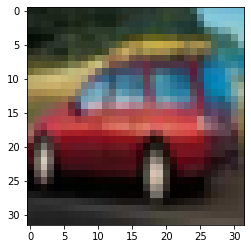

In [7]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [8]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))
print("Check the mean:", Conv2d(my_image).mean((2,3)))

Filter weights: [[[[ 0.7304995   0.68030566]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.1027988   0.09823449  0.08189838 ...  0.7525325   0.73205984
     0.72146255]
   [ 0.14844203  0.12636709  0.12754159 ...  0.7793448   0.76264036
     0.758076  ]
   [ 0.15300635  0.12562041  0.1503632  ...  0.7925383   0.7784523
     0.7753319 ]
   ...
   [ 0.20083013  0.19170149  0.19170149 ...  0.27218533  0.27674964
     0.29044262]
   [ 0.16887988  0

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [103]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  strides = 1

  # Retrieve dimensions from images shape  
  (m, n_C_prev, n_H_prev, n_W_prev) = my_image.shape
    
  # Retrieve dimensions from filter weight shape
  (f, f, n_C_prev, n_C) = initial_filter_weights.shape
    
  # Compute the dimensions of the CONV output
  n_H = int((n_H_prev - 3)/strides) + 1
  n_W =int((n_W_prev - 2)/strides) + 1

  # Initialize the output volume Z with zeros
  Z = np.zeros((m, n_C, n_H, n_W))

  for c in range(n_C): # loop over new channels
    for h in range(n_H): # loop over vertical axis of output
      for w in range(n_W): # loop over horizontal axis of output
        #a_slice_prev_no_pad = a_prev_no_pad[c,h:(h+f),w:(w+f)]
        a_slice_prev_no_pad = my_image[0,:,h:(h+3),w:(w+2)]

        # Convolve the slice 
        Z[0, c, h, w] = np.sum(np.multiply(initial_filter_weights[:, :, :, :], a_slice_prev_no_pad))

  my_conv_output = Z

  return my_conv_output

In [106]:
print(filter_weights)

[[[[ 0.7304995   0.68030566]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]


In [104]:
print("My Conv output:", my_conv_net(my_image, filter_weights))
print("My Conv output shape:", np.shape(my_conv_net(my_image, filter_weights)))

print(Conv2d(my_image)==my_conv_net(my_image, filter_weights))


np.array_equal(Conv2d(my_image),my_conv_net(my_image, filter_weights))

My Conv output: [[[[ 0.01067146  0.10871273  0.10211551 ...  0.96396428  0.94023093
     0.91866815]
   [ 0.13530491  0.19506545  0.1000957  ...  0.96601836  1.10431954
     1.04730639]
   [ 0.29475995  0.29360184  0.23272175 ...  1.22628838  1.46489988
     1.34725933]
   ...
   [-0.1243082  -0.21839786 -0.29225268 ...  0.23100909  0.28178629
     0.34292764]
   [ 0.27992359  0.34656045  0.35867804 ...  0.29725417  0.31624255
     0.34276004]
   [ 0.29999862  0.31906344  0.33847274 ...  0.32933923  0.33331608
     0.35855817]]

  [[ 0.01067146  0.10871273  0.10211551 ...  0.96396428  0.94023093
     0.91866815]
   [ 0.13530491  0.19506545  0.1000957  ...  0.96601836  1.10431954
     1.04730639]
   [ 0.29475995  0.29360184  0.23272175 ...  1.22628838  1.46489988
     1.34725933]
   ...
   [-0.1243082  -0.21839786 -0.29225268 ...  0.23100909  0.28178629
     0.34292764]
   [ 0.27992359  0.34656045  0.35867804 ...  0.29725417  0.31624255
     0.34276004]
   [ 0.29999862  0.31906344  0.33

TypeError: ignored

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [96]:
#Check that .mean((2,3)) rearranges your image
my_conv_output = my_conv_net(my_image, filter_weights)
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388898]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [97]:
#PUT YOUR CODE HERE
X = Conv2d(my_image).mean((2,3))
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)


TypeError: ignored

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

In [ ]:
#PUT YOUR CODE HERE (Use as many cells as you want)

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.